In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report

# Load dataset
df = pd.read_csv(r"D:/EPL/pl-tables-1993-2024.csv")

# Preview
print(df.head())
print(df.info())

   season_end_year            team  position  played  won  drawn  lost  gf  \
0             1993  Manchester Utd         1      42   24     12     6  67   
1             1993     Aston Villa         2      42   21     11    10  57   
2             1993    Norwich City         3      42   21      9    12  61   
3             1993       Blackburn         4      42   20     11    11  68   
4             1993             QPR         5      42   17     12    13  63   

   ga  gd  points                                 notes  
0  31  36      84  → Champions League via league finish  
1  40  17      74          → UEFA Cup via league finish  
2  65  -4      72        → UEFA Cup via league finish 1  
3  46  22      71                                   NaN  
4  55   8      63                                   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           -----------

In [3]:
# Drop the 'notes' column (not useful for prediction)
df.drop(columns=["notes"], inplace=True)

# Preview again
print(df.head())

   season_end_year            team  position  played  won  drawn  lost  gf  \
0             1993  Manchester Utd         1      42   24     12     6  67   
1             1993     Aston Villa         2      42   21     11    10  57   
2             1993    Norwich City         3      42   21      9    12  61   
3             1993       Blackburn         4      42   20     11    11  68   
4             1993             QPR         5      42   17     12    13  63   

   ga  gd  points  
0  31  36      84  
1  40  17      74  
2  65  -4      72  
3  46  22      71  
4  55   8      63  


In [4]:
# Check duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


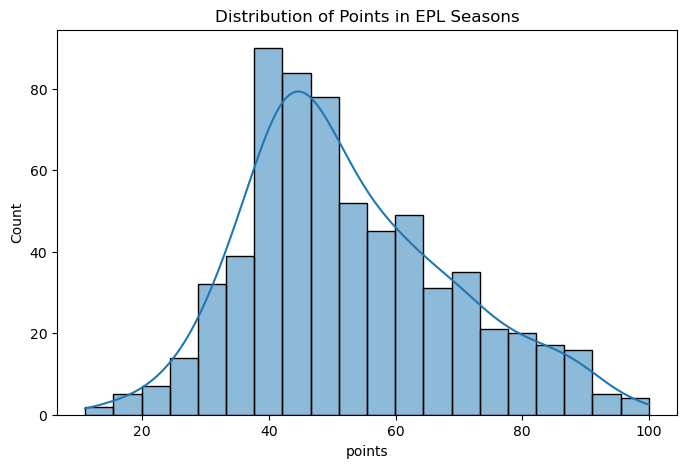

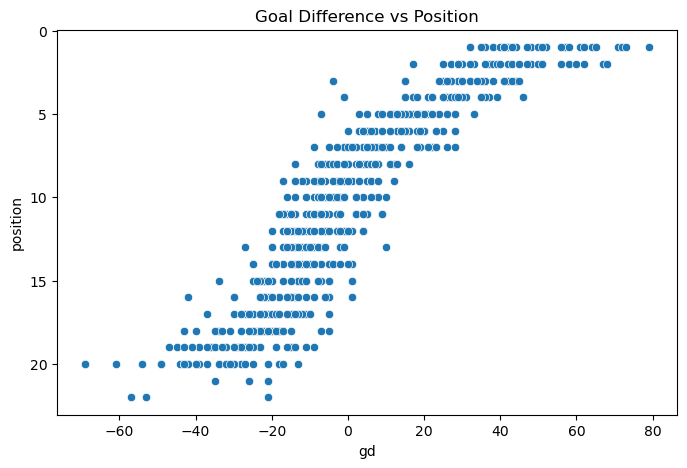

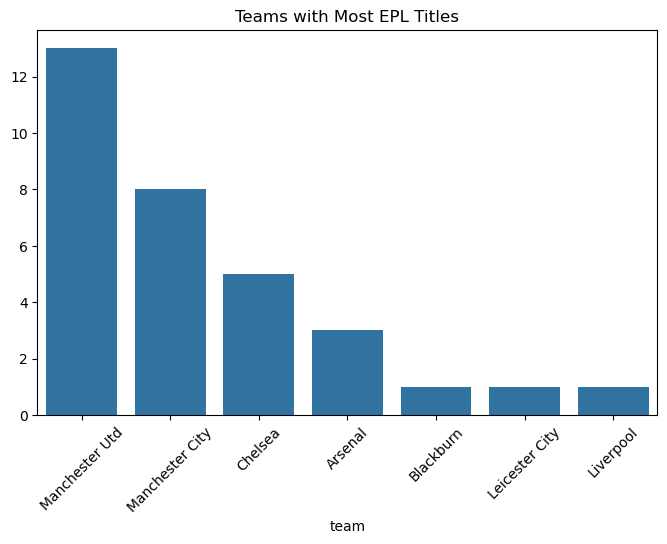

In [5]:
# Points distribution
plt.figure(figsize=(8,5))
sns.histplot(df['points'], bins=20, kde=True)
plt.title("Distribution of Points in EPL Seasons")
plt.show()

# Goal Difference vs Position
plt.figure(figsize=(8,5))
sns.scatterplot(x="gd", y="position", data=df)
plt.title("Goal Difference vs Position")
plt.gca().invert_yaxis()  # because 1st position is best
plt.show()

# Top teams with most 1st positions
winners = df[df["position"] == 1]["team"].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=winners.index, y=winners.values)
plt.title("Teams with Most EPL Titles")
plt.xticks(rotation=45)
plt.show()

In [6]:
# 1. Ratios
df["win_ratio"]   = df["won"] / df["played"]
df["draw_ratio"]  = df["drawn"] / df["played"]
df["loss_ratio"]  = df["lost"] / df["played"]

df["gf_per_match"] = df["gf"] / df["played"]
df["ga_per_match"] = df["ga"] / df["played"]
df["gd_per_match"] = df["gd"] / df["played"]

# 2. Efficiency Metrics
df["points_per_match"] = df["points"] / df["played"]
df["attack_strength"]  = df["gf"] / (df["won"] + 1)   # avoid div by 0
df["defense_strength"] = df["ga"] / (df["lost"] + 1)

# 3. Historical Context Features (using shift for same team across seasons)
df = df.sort_values(by=["team", "season_end_year"])  # ensure correct order
df["prev_points"]   = df.groupby("team")["points"].shift(1)
df["prev_position"] = df.groupby("team")["position"].shift(1)

# Fill NaN (for first season where no prev data exists)
df["prev_points"]   = df["prev_points"].fillna(0)
df["prev_position"] = df["prev_position"].fillna(df["position"].max())

# 4. Binary Flags
df["is_champion"]  = (df["position"] == 1).astype(int)
df["is_relegated"] = (df["position"] >= 18).astype(int)  # for 20-team EPL

# 5. Interaction Features
df["attack_defense_ratio"] = df["gf_per_match"] / (df["ga_per_match"] + 1)

In [7]:
# Outlier detection using IQR
numeric_cols = ["played", "won", "drawn", "lost", "gf", "ga", "gd", "points"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"Outliers in {col}: {outliers.shape[0]}")

Outliers in played: 66
Outliers in won: 3
Outliers in drawn: 0
Outliers in lost: 0
Outliers in gf: 13
Outliers in ga: 8
Outliers in gd: 11
Outliers in points: 4


In [33]:
# Apply One-Hot Encoding to 'team_name' column
df_ohe = pd.get_dummies(df, columns=["team_name"], drop_first=False)

# Keep original team_name column separately
df_ohe["team_name"] = df["team_name"]

# Preview the result
print(df_ohe.head())


    season_end_year  position  played  won  drawn  lost  gf  ga  gd  points  \
9              1993        10      42   15     11    16  40  38   2      56   
25             1994         4      42   18     17     7  53  28  25      71   
55             1995        12      42   13     12    17  53  49   4      51   
70             1996         5      38   17     12     9  49  32  17      63   
88             1997         3      38   19     11     8  62  32  30      68   

    ...  team_name_Swansea City  team_name_Swindon Town  team_name_Tottenham  \
9   ...                   False                   False                False   
25  ...                   False                   False                False   
55  ...                   False                   False                False   
70  ...                   False                   False                False   
88  ...                   False                   False                False   

    team_name_Watford  team_name_West Brom  

In [ ]:
le = LabelEncoder()
df['position'] = le.fit_transform(df['position'])

# Preview the result
print(df.head())

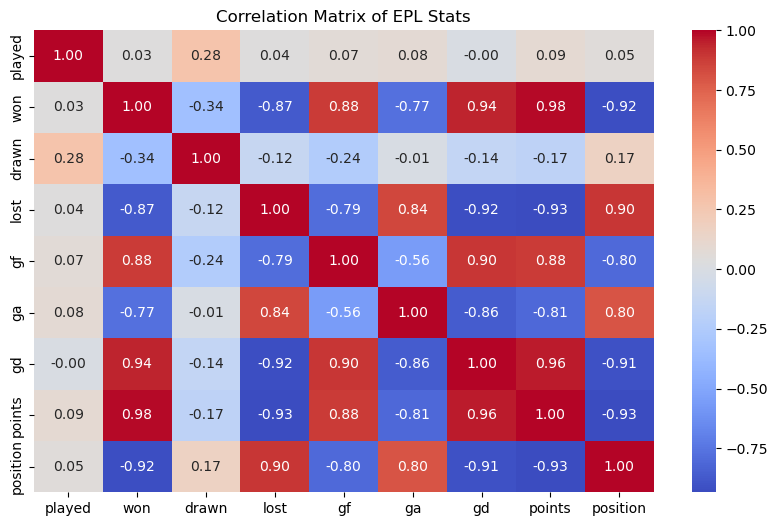

In [9]:
# Select only numeric performance-related features
numeric_cols = ["played", "won", "drawn", "lost", "gf", "ga", "gd", "points", "position"]

# Compute correlation
corr = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of EPL Stats")
plt.show()

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
# Features & Targets
# Drop target columns
X = df.drop(columns=["points", "position", "gd", "gf"])   
y = df[["points", "gd", "gf"]]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# MultiOutput Regressor
base_model = RandomForestRegressor(n_estimators=300, random_state=42)
multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, y_train)

# Predictions
y_pred = multi_model.predict(X_test)
df[["pred_points", "pred_gd", "pred_gf"]] = multi_model.predict(X)

# Metrics
print("Regression Results:")
for i, col in enumerate(["points", "gd", "gf"]):
    mae = mean_absolute_error(y_test[col], y_pred[:, i])
    r2 = r2_score(y_test[col], y_pred[:, i])
    print(f"{col} → MAE: {mae:.3f}, R²: {r2:.3f}")
print("-"*40)

# Team Names (from one-hot)
team_cols = [col for col in df.columns if col.startswith("team_")]

def get_team_name(row):
    for col in team_cols:
        if row[col] == 1:
            return col.replace("team_", "")
    return None

df["team_name"] = df.apply(get_team_name, axis=1)

# Predict Champions per Season
def get_predicted_champions(df):
    champions = {}
    for season, group in df.groupby("season_end_year"):
        group_sorted = group.sort_values(
            by=["pred_points", "pred_gd", "pred_gf"], 
            ascending=[False, False, False]
        )
        champions[season] = group_sorted.iloc[0]["team_name"]
    return champions

predicted_champions = get_predicted_champions(df)

print("Predicted Champions by Season:")
for season, team in predicted_champions.items():
    print(season, "→", team)

# Compare with Actual Champions
actual_champions = (
    df[df["position"] == 1]
    .set_index("season_end_year")["team_name"]
    .to_dict()
)

correct = sum(predicted_champions[s] == actual_champions[s] for s in actual_champions)
total = len(actual_champions)
accuracy = correct / total * 100

print(f"\n Champion Prediction Accuracy: {accuracy:.2f}%")


Regression Results:
points → MAE: 0.353, R²: 0.997
gd → MAE: 0.292, R²: 0.999
gf → MAE: 0.376, R²: 0.998
----------------------------------------
Predicted Champions by Season:
1993 → Manchester Utd
1994 → Manchester Utd
1995 → Blackburn
1996 → Manchester Utd
1997 → Manchester Utd
1998 → Arsenal
1999 → Manchester Utd
2000 → Manchester Utd
2001 → Manchester Utd
2002 → Arsenal
2003 → Manchester Utd
2004 → Arsenal
2005 → Chelsea
2006 → Chelsea
2007 → Manchester Utd
2008 → Manchester Utd
2009 → Manchester Utd
2010 → Chelsea
2011 → Manchester Utd
2012 → Manchester City
2013 → Manchester Utd
2014 → Manchester City
2015 → Chelsea
2016 → Leicester City
2017 → Chelsea
2018 → Manchester City
2019 → Manchester City
2020 → Liverpool
2021 → Manchester City
2022 → Manchester City
2023 → Manchester City
2024 → Manchester City

 Champion Prediction Accuracy: 100.00%


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# -----------------------------
# 1. Prepare features and targets
# -----------------------------
# Drop target columns from features
X = df.drop(columns=["points", "gd", "gf", "pred_points", "pred_gd", "pred_gf"], errors='ignore')
y = df[["points", "gd", "gf"]]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Train-test split (you can also do temporal split if needed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 2. Preprocessing pipeline
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)

# -----------------------------
# 3. Base model + MultiOutput
# -----------------------------
base_model = RandomForestRegressor(random_state=42)
multi_model = MultiOutputRegressor(base_model)

# Combine preprocessing + model in a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', multi_model)
])

# -----------------------------
# 4. Hyperparameter grid
# -----------------------------
param_grid = {
    'model__estimator__n_estimators': [100, 200, 300],
    'model__estimator__max_depth': [None, 10, 20],
    'model__estimator__min_samples_split': [2, 5],
    'model__estimator__min_samples_leaf': [1, 2],
    'model__estimator__max_features': ['sqrt', 'log2', None]
}

# -----------------------------
# 5. GridSearchCV for multi-output regression
# -----------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# -----------------------------
# 6. Predict on all data
# -----------------------------
best_model = grid_search.best_estimator_
df[["pred_points", "pred_gd", "pred_gf"]] = best_model.predict(X)

# -----------------------------
# 7. Champion prediction per season
# -----------------------------
def get_predicted_champions(df):
    champions = {}
    for season, group in df.groupby("season_end_year"):
        group_sorted = group.sort_values(
            by=["pred_points", "pred_gd", "pred_gf"],
            ascending=[False, False, False]
        )
        champions[season] = group_sorted.iloc[0]["team_name"]
    return champions

predicted_champions = get_predicted_champions(df)

# -----------------------------
# 8. Accuracy check
# -----------------------------
actual_champions = (
    df[df["position"] == 1]
    .set_index("season_end_year")["team_name"]
    .to_dict()
)

correct = sum(predicted_champions[s] == actual_champions[s] for s in actual_champions)
total = len(actual_champions)
accuracy = correct / total * 100

print(f"\n Champion Prediction Accuracy after Hyperparameter Tuning: {accuracy:.2f}%")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'model__estimator__max_depth': None, 'model__estimator__max_features': None, 'model__estimator__min_samples_leaf': 1, 'model__estimator__min_samples_split': 2, 'model__estimator__n_estimators': 300}

 Champion Prediction Accuracy after Hyperparameter Tuning: 100.00%


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

# -----------------------------
# 1. Temporal Train-Test Split
# -----------------------------
train_years = df["season_end_year"] <= 2018
test_years = df["season_end_year"] > 2018

X_train = X[train_years]
X_test  = X[test_years]

y_train = df.loc[train_years, ["points", "gd", "gf"]]
y_test  = df.loc[test_years, ["points", "gd", "gf"]]

# -----------------------------
# 2. Fit Multi-output Random Forest
# -----------------------------
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

base_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42
)
multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, y_train)

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
y_pred = multi_model.predict(X_test)
df.loc[test_years, ["pred_points", "pred_gd", "pred_gf"]] = y_pred

# -----------------------------
# 4. Print Regression Metrics
# -----------------------------
for i, col in enumerate(["points", "gd", "gf"]):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2  = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col} → MAE: {mae:.3f}, R²: {r2:.3f}")

# -----------------------------
# 5. Predict Champions & Accuracy
# -----------------------------
def get_predicted_champions(df_subset):
    champions = {}
    for season, group in df_subset.groupby("season_end_year"):
        group_sorted = group.sort_values(
            by=["pred_points", "pred_gd", "pred_gf"],
            ascending=[False, False, False]
        )
        champions[season] = group_sorted.iloc[0]["team_name"]
    return champions

predicted_champions = get_predicted_champions(df[test_years])
actual_champions = (
    df[(test_years) & (df["position"] == 1)]
    .set_index("season_end_year")["team_name"]
    .to_dict()
)


correct = sum(predicted_champions[s] == actual_champions[s] for s in actual_champions)
total = len(actual_champions)
accuracy = correct / total * 100

print(f"\nChampion Prediction Accuracy: {accuracy:.2f}%")


points → MAE: 0.415, R²: 0.998
gd → MAE: 0.561, R²: 0.997
gf → MAE: 0.231, R²: 0.999

Champion Prediction Accuracy: 100.00%


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score

# -------------------
# 1. Prepare features
# -------------------
# Exclude 'winner' (target) and 'team_name' (identifier, not a feature)
features = [col for col in df.columns if col not in ["winner", "team_name"]]
target = "winner"

# Train on seasons up to 2020, predict after 2020
train_df = df[df["season_end_year"] <= 2020]
test_df  = df[df["season_end_year"] > 2020]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test   = test_df[features], test_df[target]

# -------------------
# 2. Build pipeline
# -------------------
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

# -------------------
# 3. Train model
# -------------------
clf.fit(X_train, y_train)

# -------------------
# 4. Predict on FUTURE seasons
# -------------------
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # probability of being champion
y_pred = clf.predict(X_test)

# -------------------
# 5. Evaluation (how well it did on holdout years)
# -------------------
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R²: {r2}")

# -------------------
# 6. Attach results with team_name
# -------------------
results = pd.DataFrame({
    "season_end_year": test_df["season_end_year"],
    "team_name": test_df["team_name"],
    "winner_prob": y_pred_proba
}).sort_values(by="winner_prob", ascending=False)

# -------------------
# 7. Show predictions
# -------------------
champions = results.loc[results.groupby("season_end_year")["winner_prob"].idxmax()]
for year, row in champions.iterrows():
    print(f" Predicted Champion for {row['season_end_year']}: {row['team_name']}")

print("\n Full Predictions:")
print(results.head(20))  # top 20 rows


MAE: 0.0
R²: 1.0
 Predicted Champion for 2021: Manchester City
 Predicted Champion for 2022: Manchester City
 Predicted Champion for 2023: Manchester City
 Predicted Champion for 2024: Manchester City

 Full Predictions:
     season_end_year        team_name  winner_prob
586             2022  Manchester City        0.925
606             2023  Manchester City        0.915
626             2024  Manchester City        0.915
566             2021  Manchester City        0.895
627             2024          Arsenal        0.280
587             2022        Liverpool        0.225
628             2024        Liverpool        0.080
609             2023    Newcastle Utd        0.075
607             2023          Arsenal        0.065
567             2021   Manchester Utd        0.045
588             2022          Chelsea        0.030
631             2024          Chelsea        0.025
610             2023        Liverpool        0.020
632             2024    Newcastle Utd        0.015
590           